# GAN

Conventional Generative Adversarial Network.

The model is as in the figure:

<img src="./Images/gans.png" width="500px"></img>

In [1]:
# Dependencies

import torch
import os
import torch.nn as nn
import numpy as np
import torchvision
from torchvision.utils import make_grid
from tqdm import tqdm
from torch.optim import Adam
# from dataset.mnist_dataset import MnistDataset
from torch.utils.data import DataLoader
!pip install -q -U datasets matplotlib tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.6 MB/s eta 0:00:00


In [2]:
# Configurations used for Creating and training the GAN

LATENT_DIM = 64               # Initial Dimension
IM_CHANNELS = 1               # For colored mnist change below to 3
IM_PATH = 'data/train/images' # ?
IM_EXT = 'png'                # ?
IM_SIZE = (28, 28)            # Image size
BATCH_SIZE = 128              # Batch size
NUM_EPOCHS = 50               # Number of Epochs
NUM_SAMPLES = 225             # Number of samples
NROWS = 15                    # ?

In [3]:
layers_dim = [LATENT_DIM, 128, 256, 512, IM_SIZE[0] * IM_SIZE[1] * IM_CHANNELS]
layers_dim

[64, 128, 256, 512, 784]

### Generator

The Generator is made of 5-1 =4 layers which go like

Example:- [64, 128, 256, 512, 784]

This takes a gaussian input of 64, and returns an ouput of 784, while each layer transformation is made of:

* Linear Layer
* BatchNorm
* Activation (Leaky Relu) (Tanh for last layer to put [-1,+1])

In [4]:
class Generator(nn.Module):
    """
    Generator for the GAN

    Input: z : 64 size vector (from a gaussian dist)

    Output: out (an image of the specified shape eg. 28x28)
    """
    def __init__(self):
        super().__init__()

        self.latent_dim = LATENT_DIM
        self.img_size = IM_SIZE
        self.channels = IM_CHANNELS

        activation = nn.LeakyReLU()

        layers_dim = [self.latent_dim, 128, 256, 512, self.img_size[0] * self.img_size[1] * self.channels]
        # eg. [64, 128, 256, 512, 784]

        # A module of the nn layers, for each layer
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(layers_dim[i], layers_dim[i + 1]),
                # For the last layer, we do not keep batch norm
                nn.BatchNorm1d(layers_dim[i + 1]) if i != len(layers_dim) - 2 else nn.Identity(),
                activation if i != len(layers_dim) - 2 else nn.Tanh()
            )
            for i in range(len(layers_dim) - 1)
        ])

    def forward(self, z):
        batch_size = z.shape[0]
        out = z.reshape(-1, self.latent_dim) # out = (batches, latent_dim (64))

        # Interate through the layers
        for layer in self.layers:
            out = layer(out)
        out = out.reshape(batch_size, self.channels, self.img_size[0], self.img_size[1])
        return out

### Discriminator

In [5]:
class Discriminator(nn.Module):
    """
    Duscrminator for the GAN

    Input: x : (IMG_H*IMG_W*IMG_CHANNELS) size image tensor (from a gaussian dist)

    Output: out (a binary variable 1= real, 0 = fake, but NOTE: it Outputs Logits)
    """
    def __init__(self):
        super().__init__()
        self.img_size = IM_SIZE
        self.channels = IM_CHANNELS
        activation = nn.LeakyReLU()

        layers_dim = [self.img_size[0] * self.img_size[1] * self.channels, 512, 256, 128, 1]
        # eg. [784, 512, 256, 128, 1]

        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(layers_dim[i], layers_dim[i + 1]),
                nn.LayerNorm(layers_dim[i + 1]) if i != len(layers_dim) - 2 else nn.Identity(),
                activation if i != len(layers_dim) - 2 else nn.Identity()
            )
            for i in range(len(layers_dim) - 1)
        ])

    def forward(self, x):

        # Flattening the image to (batches, 728)
        out = x.reshape(-1, self.img_size[0] * self.img_size[1] * self.channels)
        for layer in self.layers:
            out = layer(out)
        return out

## Datasets and Dataloader

In [6]:
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader

image_size = 28
channels = 1
batch_size = 128
torch.manual_seed(0)

# Loading dataset from the Hugging face hub
dataset = load_dataset("fashion_mnist")

# Define Image transformations (using torchvision), including a random horizontal flip
# The data is [0,1], so converted to [-1,+1]
transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

# Define Transform function
def transforms(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

transformed_dataset = dataset.with_transform(transforms).remove_columns("label")

# Create a pytorch Dataloader Object
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)
mnist_loader = dataloader

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for fashion_mnist contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fashion_mnist
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.war

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [7]:
batch = next(iter(dataloader))
print(batch.keys())

# Each batch has 128 images of size 28x28
print(batch['pixel_values'].shape)

num_batches = len(dataloader)
print("num of batches: ",num_batches)
print("batch size: ", dataloader.batch_size)

total_images = len(dataloader.dataset)
print("Total no of images: ", total_images)

dict_keys(['pixel_values'])
torch.Size([128, 1, 28, 28])
num of batches:  469
batch size:  128
Total no of images:  60000


## Training the Model

The losses are as follows:-

* Discriminator Loss = D(x) - D(G(z))

<img src="./Images/dis_loss.png" width="500px"></img>

* Generator Loss = -D(G(z))

<img src="./Images/gen_loss.png" width="400px"></img>


In [8]:
import time

############## Instantiate Model ##############
generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator.train()
discriminator.train()

############## Training Optimizers (Adam) ##############
optimizer_generator = Adam(generator.parameters(), lr=1E-4, betas=(0.5, 0.999))
optimizer_discriminator = Adam(discriminator.parameters(), lr=1E-4, betas=(0.5, 0.999))

############## Loss function ##############
criterion = torch.nn.BCEWithLogitsLoss() # Logit loss

############## Training ##############
steps = 0
generated_sample_count = 0
start_time = time.time()

for epoch_idx in range(NUM_EPOCHS):
  generator_losses = []
  discriminator_losses = []
  # We also store the mean real and fake predictions of discriminator
  mean_real_dis_preds = []
  mean_fake_dis_preds = []

  # Enumerates over the mnist loader
  # for im in tqdm(mnist_loader):
  for step, batch in enumerate(mnist_loader):
      real_ims = batch["pixel_values"].to(device)
      batch_size = batch["pixel_values"].shape[0]

      # Optimize Discriminator
      optimizer_discriminator.zero_grad()

      # Create images using the generator
      fake_im_noise = torch.randn((batch_size, LATENT_DIM), device=device)
      fake_ims = generator(fake_im_noise)

      real_label = torch.ones((batch_size, 1), device=device)
      fake_label = torch.zeros((batch_size, 1), device=device)

      # Real and fake image prediction (fake ones detaches to not backprop to generator)
      disc_real_pred = discriminator(real_ims)
      disc_fake_pred = discriminator(fake_ims.detach())
      disc_real_loss = criterion(disc_real_pred.reshape(-1), real_label.reshape(-1))
      mean_real_dis_preds.append(torch.nn.Sigmoid()(disc_real_pred).mean().item())

      disc_fake_loss = criterion(disc_fake_pred.reshape(-1), fake_label.reshape(-1))
      mean_fake_dis_preds.append(torch.nn.Sigmoid()(disc_fake_pred).mean().item())
      disc_loss = (disc_real_loss + disc_fake_loss) / 2
      disc_loss.backward()
      optimizer_discriminator.step()
      ########################

      # Optimize Generator
      optimizer_generator.zero_grad()
      fake_im_noise = torch.randn((batch_size, LATENT_DIM), device=device)
      fake_ims = generator(fake_im_noise)
      disc_fake_pred = discriminator(fake_ims)
      gen_fake_loss = criterion(disc_fake_pred.reshape(-1), real_label.reshape(-1))
      gen_fake_loss.backward()
      optimizer_generator.step()
      ########################

      generator_losses.append(gen_fake_loss.item())
      discriminator_losses.append(disc_loss.item())

      # Saving samples
      # if steps % 50 == 0:
      #     with torch.no_grad():
      #         generator.eval()
      #         infer(generated_sample_count, generator)
      #         generated_sample_count += 1
      #         generator.train()
      #############

      steps += 1
  print('Finished epoch:{} | Generator Loss : {:.4f} | Discriminator Loss : {:.4f} | '
            'Discriminator real pred : {:.4f} | Discriminator fake pred : {:.4f}'.format(
          epoch_idx + 1,
          np.mean(generator_losses),
          np.mean(discriminator_losses),
          np.mean(mean_real_dis_preds),
          np.mean(mean_fake_dis_preds),
      ))

  # Saving the trained models
  # torch.save(generator.state_dict(), 'generator_ckpt.pth')
  # torch.save(discriminator.state_dict(), 'discriminator_ckpt.pth')

end_time = time.time()
elapsed_time = end_time - start_time
print('Done Training ...')
print("Execution time:", elapsed_time, "seconds")

Finished epoch:1 | Generator Loss : 2.2204 | Discriminator Loss : 0.2879 | Discriminator real pred : 0.7988 | Discriminator fake pred : 0.2115
Finished epoch:2 | Generator Loss : 1.7776 | Discriminator Loss : 0.3954 | Discriminator real pred : 0.7215 | Discriminator fake pred : 0.2766
Finished epoch:3 | Generator Loss : 1.8158 | Discriminator Loss : 0.3901 | Discriminator real pred : 0.7305 | Discriminator fake pred : 0.2684
Finished epoch:4 | Generator Loss : 1.7382 | Discriminator Loss : 0.4126 | Discriminator real pred : 0.7220 | Discriminator fake pred : 0.2768
Finished epoch:5 | Generator Loss : 1.7444 | Discriminator Loss : 0.4150 | Discriminator real pred : 0.7219 | Discriminator fake pred : 0.2770
Finished epoch:6 | Generator Loss : 1.7398 | Discriminator Loss : 0.4139 | Discriminator real pred : 0.7225 | Discriminator fake pred : 0.2748
Finished epoch:7 | Generator Loss : 1.7125 | Discriminator Loss : 0.4153 | Discriminator real pred : 0.7226 | Discriminator fake pred : 0.2744

### Saving and loading the model

In [10]:
torch.save(generator.state_dict(), 'generator_ckpt.pth')
torch.save(discriminator.state_dict(), 'discriminator_ckpt.pth')

In [11]:
# Loading the model
gen_load_path = 'generator_ckpt.pth'
dis_load_path = 'discriminator_ckpt.pth'

generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Load the saved model parameters into the model instance
generator.load_state_dict(torch.load(gen_load_path))
discriminator.load_state_dict(torch.load(dis_load_path))

<All keys matched successfully>

## Sampling from the Model

We will sample some images from the trained generator and check the results

In [14]:
fake_im_noise = torch.randn((NUM_SAMPLES, LATENT_DIM), device=device)
fake_ims = generator(fake_im_noise)

# Converting the images to PIL
ims = torch.clamp(fake_ims, -1., 1.).detach().cpu()
ims = (ims + 1) / 2
grid = make_grid(ims, nrow=NROWS)
img = torchvision.transforms.ToPILImage()(grid)

# print(img.shape)

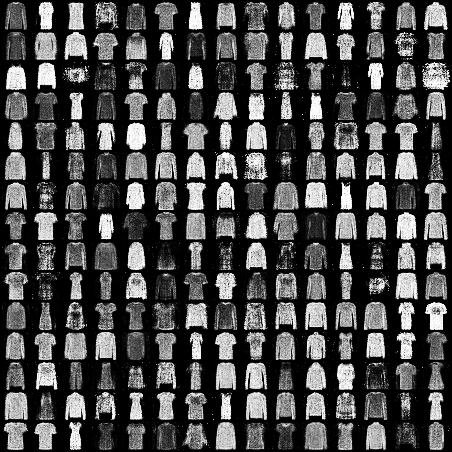

In [15]:
img

In [ ]:
import matplotlib.pyplot as plt

torch.manual_seed(0)

def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        # row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()